Gestational Diabetes Using XAI

Preprocessing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import warnings

warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("gestational_diabetes.csv")

In [5]:
df.head()

,GDM,AP,ICP,TD,Eclampsia,Twins,Day,Age,ALT,AST,...,TBA,UREA,CREA,UA,BMG,A1MG,CysC,CO2,FPG,BMI
0,0,0,0,0,0,0,119,29,12.900000,18.300000,...,2.500000,2.940000,50.50000,211.100000,1.340000,21.050000,0.700000,24.000000,5.410000,38.021780
1,0,0,0,0,0,0,165,30,19.267422,20.341909,...,1.593159,2.689873,67.27318,220.210738,0.952367,19.626514,0.640272,24.238539,4.708611,36.471451
2,0,0,0,0,0,0,85,35,16.800000,14.400000,...,1.600000,2.580000,50.50000,189.200000,0.870000,18.420000,0.500000,24.800000,5.290000,52.455713
3,0,0,0,0,0,0,134,36,19.267422,20.341909,...,1.593159,2.689873,67.27318,220.210738,0.952367,19.626514,0.640272,24.238539,4.708611,49.184689
4,0,0,0,0,0,0,77,32,11.900000,16.200000,...,1.300000,1.980000,43.90000,188.600000,0.840000,18.310000,0.600000,20.900000,5.100000,35.396311


In [6]:
# 1) Quick inspection
print("Shape:", df.shape)
print("\nTarget counts (GDM):")
print(df["GDM"].value_counts())
print("\nTotal missing values:", df.isna().sum().sum())

Shape: (5700, 26)

Target counts (GDM):
GDM
0    4459
1    1241
Name: count, dtype: int64

Total missing values: 0


In [7]:
# 2) Negative value check (medical labs shouldn't be negative)
neg_counts = (df < 0).sum()
neg_counts = neg_counts[neg_counts > 0].sort_values(ascending=False)
print("\nColumns with negative values (counts):")
print(neg_counts if not neg_counts.empty else "None found")

# If negatives exist, drop rows containing any negative value (simple and safe for now)
df_clean = df.copy()
if not neg_counts.empty:
    before = df_clean.shape[0]
    df_clean = df_clean[(df_clean >= 0).all(axis=1)]
    after = df_clean.shape[0]
    print(f"Dropped {before-after} rows containing negative values.")
else:
    print("No negative-value rows to drop.")


Columns with negative values (counts):
None found
No negative-value rows to drop.


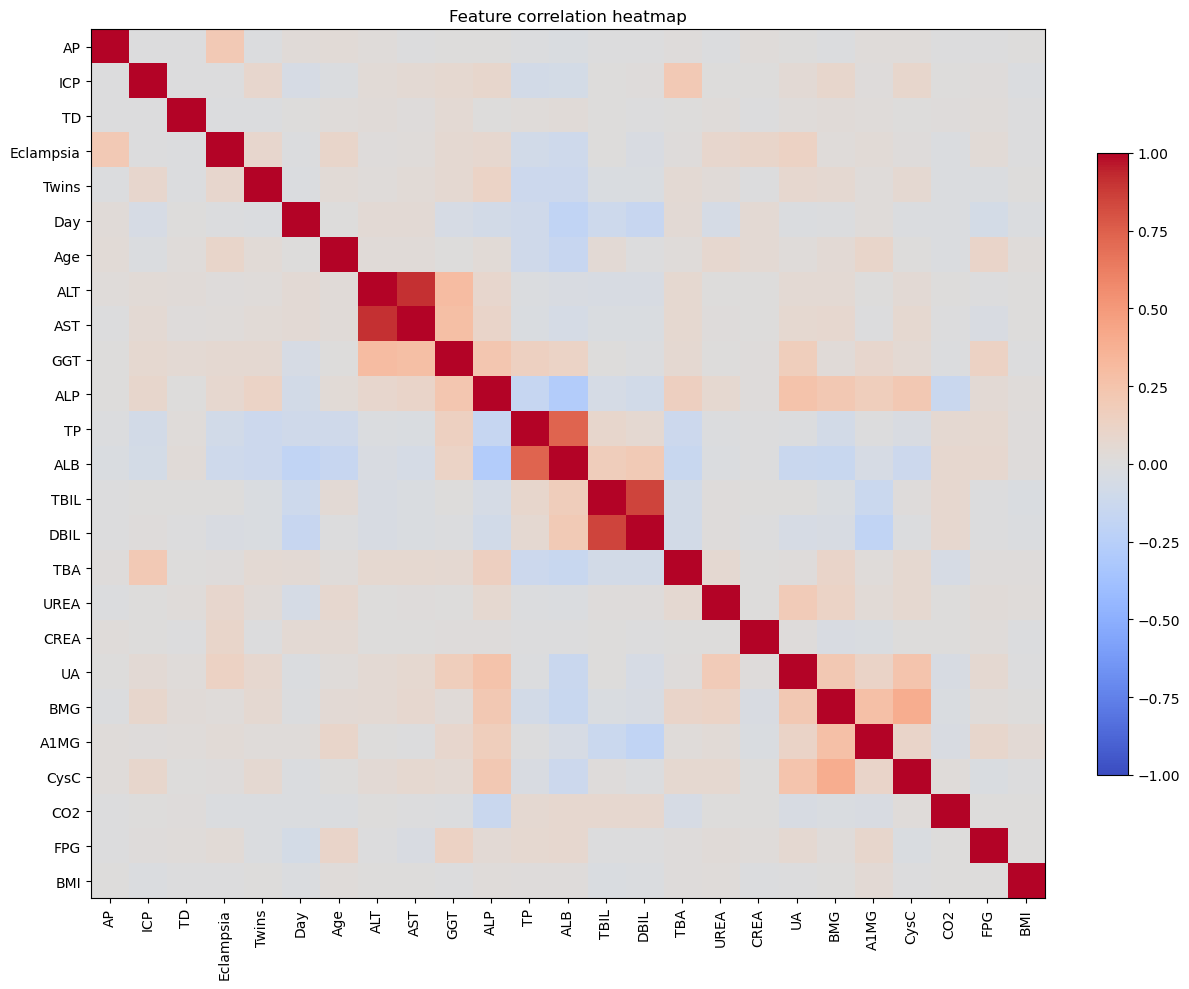

In [8]:
# 3) Correlation heatmap (features only)
X = df_clean.drop("GDM", axis=1)
y = df_clean["GDM"]

plt.figure(figsize=(12, 10))
corr = X.corr()
plt.imshow(corr, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(fraction=0.03)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature correlation heatmap")
plt.tight_layout()
plt.show()

In [9]:
# Print highly correlated pairs (abs > 0.85)
threshold = 0.85
high_corr = []
cols = corr.columns.tolist()
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if abs(corr.iloc[i, j]) > threshold:
            high_corr.append((cols[i], cols[j], corr.iloc[i, j]))
print("\nHighly correlated pairs (abs(corr) > 0.85):")
if high_corr:
    for a, b, c in high_corr:
        print(f"{a} <--> {b}   corr={c:.3f}")
else:
    print("None above", threshold)


Highly correlated pairs (abs(corr) > 0.85):
ALT <--> AST   corr=0.910


In [10]:
# Generating the correlation matrix for the dataset
correlation_matrix = df.corr()

# Display the correlation matrix
correlation_matrix[["GDM"]].sort_values(by="GDM", ascending=False)

,GDM
GDM,1.000000
FPG,0.336054
Age,0.176754
A1MG,0.170393
UA,0.168533
GGT,0.147328
ALP,0.119582
BMG,0.077949
Eclampsia,0.063531
ICP,0.061228


In [11]:
target_col = "GDM"  # change this if your target column name differs
assert (
    target_col in df.columns
), f"Target column '{target_col}' not found in df columns."

# Separate features/target
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# Detect numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Total columns: {df.shape[1]} (features={X.shape[1]}, target='{target_col}')")
print(f"Numeric cols ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical cols ({len(cat_cols)}): {cat_cols}")

Total columns: 26 (features=25, target='GDM')
Numeric cols (25): ['AP', 'ICP', 'TD', 'Eclampsia', 'Twins', 'Day', 'Age', 'ALT', 'AST', 'GGT', 'ALP', 'TP', 'ALB', 'TBIL', 'DBIL', 'TBA', 'UREA', 'CREA', 'UA', 'BMG', 'A1MG', 'CysC', 'CO2', 'FPG', 'BMI']
Categorical cols (0): []


In [12]:
corr_with_target = (
    pd.concat([X[numeric_cols], y], axis=1).corr()[target_col].drop(target_col)
)
neg_features = corr_with_target[corr_with_target < 0].index.tolist()

print("\nCorrelation with target (top 10 by absolute value):")
print(corr_with_target.abs().sort_values(ascending=False).head(10))

print("\nFeatures with negative Pearson correlation to target (will be dropped):")
print(neg_features)


Correlation with target (top 10 by absolute value):
FPG          0.336054
Age          0.176754
A1MG         0.170393
UA           0.168533
GGT          0.147328
ALP          0.119582
BMG          0.077949
Eclampsia    0.063531
ICP          0.061228
DBIL         0.059475
Name: GDM, dtype: float64

Features with negative Pearson correlation to target (will be dropped):
['Twins', 'Day', 'TP', 'ALB', 'TBIL', 'DBIL', 'CO2']


In [13]:
features = ["AP", "ICP", "TD", "Eclampsia", "Age", "BMI","ALT", "AST", "GGT", "ALP", "TBA", "UREA", "CREA", "UA", "BMG","A1MG",
"CysC","FPG"]

X = df[features]

# Fit the scaler on training data
scaler = StandardScaler()
scaler.fit(X)

# Save the fitted scaler
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [14]:
X = df[features]
y = df["GDM"]

Train & Test Split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Feature Scaling - Models like:

SVM, Logistic Regression, MLP assume features are on similar scales

Prevents dominance of glucose/BMI over others

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
import pandas as pd

pd.Series(y_train).value_counts(normalize=True)

GDM
0    0.782237
1    0.217763
Name: proportion, dtype: float64

Handle Class Imbalance (SMOTE)

In [18]:
# install imbalanced-learn if missing
%pip install -q imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_balanced)
X_test_pca = pca.transform(X_test_scaled)

print("Original features:", X_train_balanced.shape[1])
print("Reduced features:", X_train_pca.shape[1])

Original features: 18
Reduced features: 16


Evaluation Setup for all models

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

results = []


def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    results.append(
        {
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1-score": f1_score(y_test, y_pred),
        }
    )

Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

lr.fit(X_train_balanced, y_train_balanced)

evaluate_model("Logistic Regression (No PCA)", lr, X_test_scaled, y_test)

In [23]:
lr_pca = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

lr_pca.fit(X_train_pca, y_train_balanced)

evaluate_model("Logistic Regression (PCA)", lr_pca, X_test_pca, y_test)

Support Vector Machine (SVM)

In [24]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    C=1,
    gamma="scale",
    class_weight="balanced",
    probability=True,
    random_state=42,
)

svm.fit(X_train_balanced, y_train_balanced)

evaluate_model("SVM (No PCA)", svm, X_test_scaled, y_test)

In [25]:
svm_pca = SVC(
    kernel="rbf",
    C=1,
    gamma="scale",
    class_weight="balanced",
    probability=True,
    random_state=42,
)

svm_pca.fit(X_train_pca, y_train_balanced)

evaluate_model("SVM (PCA)", svm_pca, X_test_pca, y_test)

Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200, max_depth=None, class_weight="balanced", random_state=42
)

rf.fit(X_train_balanced, y_train_balanced)

evaluate_model("Random Forest", rf, X_test_scaled, y_test)

MLP Classifier

In [27]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42,
)

mlp.fit(X_train_balanced, y_train_balanced)

evaluate_model("MLP", mlp, X_test_scaled, y_test)

In [28]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="Recall", ascending=False)

,Model,Accuracy,Precision,Recall,F1-score
4,Random Forest,0.954386,0.933628,0.850806,0.890295
5,MLP,0.906140,0.756364,0.838710,0.795411
1,Logistic Regression (PCA),0.779825,0.496104,0.770161,0.603476
0,Logistic Regression (No PCA),0.778070,0.493506,0.766129,0.600316
2,SVM (No PCA),0.871930,0.688889,0.750000,0.718147
3,SVM (PCA),0.870175,0.686567,0.741935,0.713178


Tuning of ML Models - SVM, LR, RF

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score

In [30]:
scoring = {"Recall": make_scorer(recall_score), "F1": make_scorer(f1_score)}

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

lr_param_grid = {
    "C": [0.01, 0.1, 1, 10],  # regularization strength
    "penalty": ["l2"],
    "solver": ["lbfgs"],
}

In [32]:
lr_grid = GridSearchCV(
    lr, lr_param_grid, cv=5, scoring=scoring, refit="Recall", n_jobs=-1
)

lr_grid.fit(X_train_balanced, y_train_balanced)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l2'], 'solver': ['lbfgs']}"
,scoring,"{'F1': make_scorer(f...hod='predict'), 'Recall': make_scorer(r...hod='predict')}"
,n_jobs,-1
,refit,'Recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [33]:
best_lr = lr_grid.best_estimator_

evaluate_model("Logistic Regression (Tuned)", best_lr, X_test_scaled, y_test)

lr_grid.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

In [34]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42)

svm_param_grid = {"C": [0.1, 1, 10], "gamma": ["scale", 0.01, 0.1]}

In [35]:
svm_grid = GridSearchCV(
    svm, svm_param_grid, cv=5, scoring=scoring, refit="Recall", n_jobs=-1
)

svm_grid.fit(X_train_balanced, y_train_balanced)

,estimator,SVC(class_wei...ndom_state=42)
,param_grid,"{'C': [0.1, 1, ...], 'gamma': ['scale', 0.01, ...]}"
,scoring,"{'F1': make_scorer(f...hod='predict'), 'Recall': make_scorer(r...hod='predict')}"
,n_jobs,-1
,refit,'Recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [36]:
best_svm = svm_grid.best_estimator_

evaluate_model("SVM (Tuned)", best_svm, X_test_scaled, y_test)

svm_grid.best_params_

{'C': 10, 'gamma': 0.1}

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)

rf_param_grid = {
    "max_depth": [5, 10, None],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 5],
}

In [38]:
rf_grid = GridSearchCV(
    rf, rf_param_grid, cv=5, scoring=scoring, refit="Recall", n_jobs=-1
)

rf_grid.fit(X_train_balanced, y_train_balanced)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_leaf': [2, 5], 'min_samples_split': [5, 10]}"
,scoring,"{'F1': make_scorer(f...hod='predict'), 'Recall': make_scorer(r...hod='predict')}"
,n_jobs,-1
,refit,'Recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [39]:
best_rf = rf_grid.best_estimator_

evaluate_model("Random Forest (Tuned)", best_rf, X_test_scaled, y_test)

rf_grid.best_params_

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

In [40]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=["Recall", "F1-score"], ascending=False)

,Model,Accuracy,Precision,Recall,F1-score
4,Random Forest,0.954386,0.933628,0.850806,0.890295
8,Random Forest (Tuned),0.951754,0.925110,0.846774,0.884211
5,MLP,0.906140,0.756364,0.838710,0.795411
1,Logistic Regression (PCA),0.779825,0.496104,0.770161,0.603476
0,Logistic Regression (No PCA),0.778070,0.493506,0.766129,0.600316
7,SVM (Tuned),0.891228,0.744094,0.762097,0.752988
6,Logistic Regression (Tuned),0.775439,0.489637,0.762097,0.596215
2,SVM (No PCA),0.871930,0.688889,0.750000,0.718147
3,SVM (PCA),0.870175,0.686567,0.741935,0.713178


In [41]:
import joblib

# Save the tuned Random Forest model
joblib.dump(best_rf, "random_forest_gdm_model.pkl")

# Save scaler
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully!")

Model and scaler saved successfully!


In [42]:
print(X_train.shape)  # should show (?, 18)

(4560, 18)


Explainable AI 

In [52]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [54]:
explainer = shap.TreeExplainer(best_rf, feature_perturbation="interventional")

In [55]:
shap_values = explainer.shap_values(X_train)

In [56]:
type(shap_values), len(shap_values)

(numpy.ndarray, 4560)

In [60]:
shap_pos = shap_values[:, :, 1]  # ✅ ONLY index 1

In [61]:
shap_pos = shap_pos[:, : X_train.shape[1]]

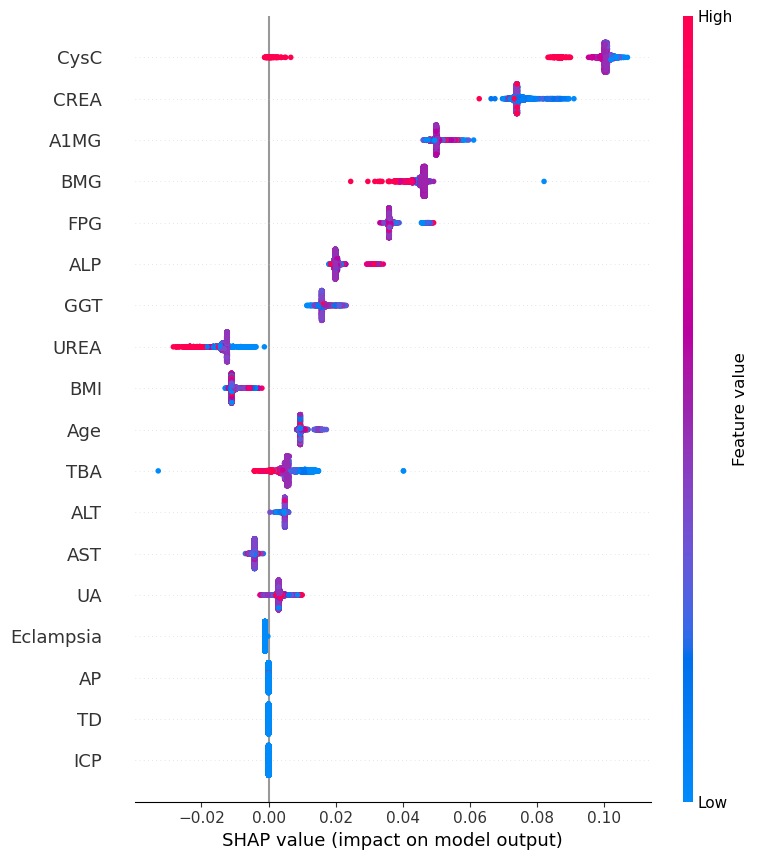

In [62]:
shap.summary_plot(shap_pos, X_train, show=True)

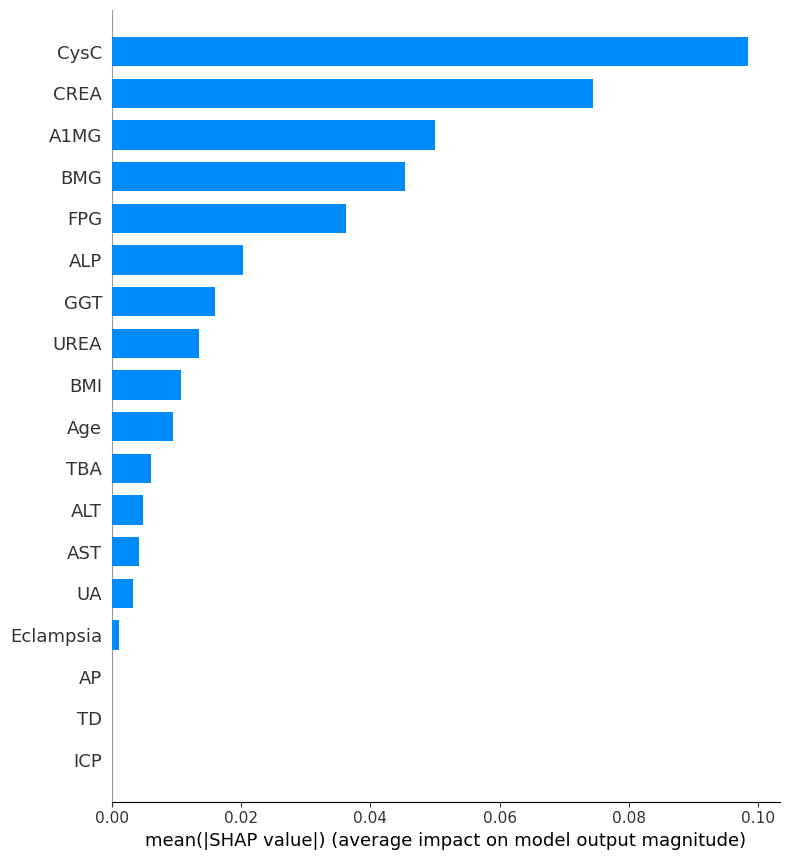

In [63]:
shap.summary_plot(shap_pos, X_train, plot_type="bar", show=True)

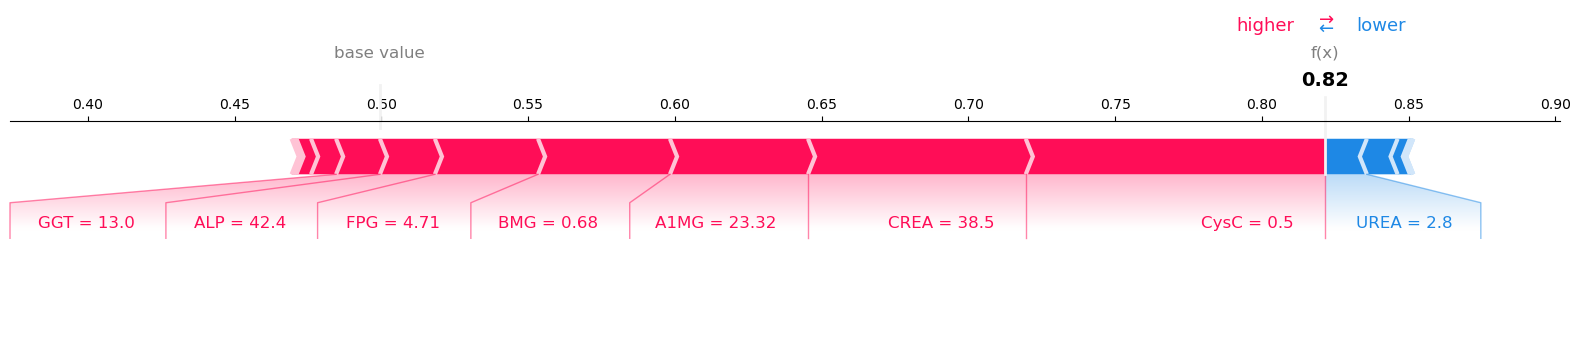

In [64]:
idx = 0

shap.force_plot(
    explainer.expected_value[1], shap_pos[idx], X_train.iloc[idx], matplotlib=True
)

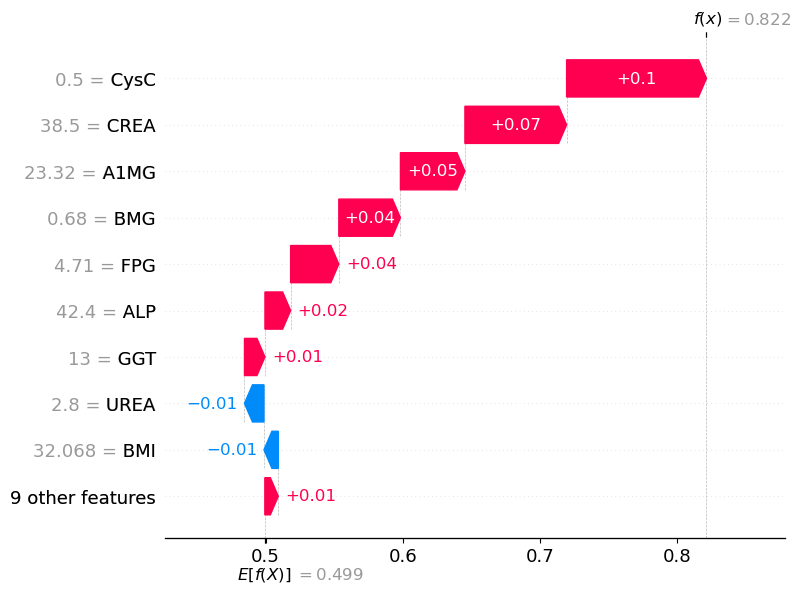

In [65]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_pos[idx],
        base_values=explainer.expected_value[1],
        data=X_train.iloc[idx],
        feature_names=X_train.columns,
    )
)

In [66]:
user_input = {
    "AP": 120,
    "ICP": 10,
    "TD": 2,
    "Eclampsia": 0,
    "Age": 28,
    "BMI": 32.0,
    "ALT": 25,
    "AST": 22,
    "GGT": 15,
    "ALP": 42,
    "TBA": 4.0,
    "UREA": 2.8,
    "CREA": 38.5,
    "UA": 280,
    "BMG": 0.68,
    "A1MG": 23.3,
    "CysC": 0.50,
    "FPG": 4.7,
}

In [67]:
input_df = pd.DataFrame([user_input])

# Ensure correct column order
input_df = input_df[features]

input_df

,AP,ICP,TD,Eclampsia,Age,BMI,ALT,AST,GGT,ALP,TBA,UREA,CREA,UA,BMG,A1MG,CysC,FPG
0,120,10,2,0,28,32.0,25,22,15,42,4.0,2.8,38.5,280,0.68,23.3,0.5,4.7


In [68]:
# Predict probabilities
probs = best_rf.predict_proba(input_df)

# Take highest probability class
pred_class = np.argmax(probs)

risk_map = {0: "LOW RISK", 1: "MODERATE RISK", 2: "HIGH RISK"}

print("Predicted Risk:", risk_map.get(pred_class, "UNKNOWN"))
print("Prediction Probabilities:", probs)

Predicted Risk: MODERATE RISK
Prediction Probabilities: [[0.18145238 0.81854762]]


In [71]:
shap_values_user = explainer.shap_values(input_df)

# Select positive class explanation
shap_user = shap_values_user[:, :, 1]

# Align features (safety)
shap_user = shap_user[:, : input_df.shape[1]]

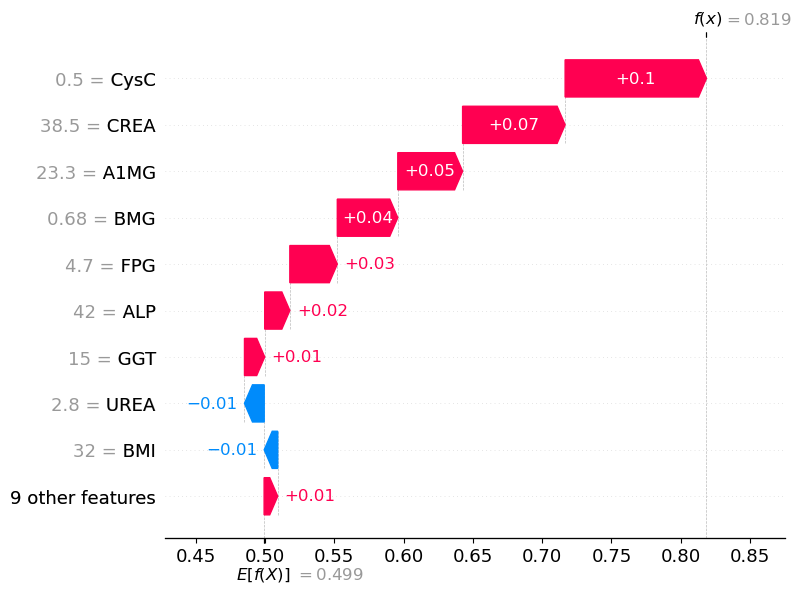

In [72]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_user[0],
        base_values=explainer.expected_value[1],
        data=input_df.iloc[0],
        feature_names=input_df.columns,
    )
)

In [73]:
shap_df = pd.DataFrame(
    {"Feature": input_df.columns, "SHAP_Value": shap_user[0]}
).sort_values(by="SHAP_Value", ascending=False)

shap_df.head(5)

,Feature,SHAP_Value
16,CysC,0.101968
12,CREA,0.073958
15,A1MG,0.046755
14,BMG,0.043626
17,FPG,0.034245


In [74]:
print("Top factors increasing risk:")
for _, row in shap_df.head(5).iterrows():
    print(f"- {row['Feature']} (impact: {row['SHAP_Value']:.3f})")

Top factors increasing risk:
- CysC (impact: 0.102)
- CREA (impact: 0.074)
- A1MG (impact: 0.047)
- BMG (impact: 0.044)
- FPG (impact: 0.034)
